# Movies Scoring and Clustering 

This notebook is an example on how to use the VerticaPy Library. We will use the filmtv_movies dataset to evaluate the quality of the movies and create clusters based on similarity. You can download the Jupyter Notebook of the study by clicking <a href="movies.ipynb">here</a>. You can download the dataset of the study by clicking <a href = "../../data/filmtv_movies.csv">here</a>. We have access to the following variables.
<ul class="ul_content">
    <li><b>year: </b>Movie Year of production</li>
    <li><b>filmtv_id: </b>Movie ID</li>
    <li><b>title: </b>Movie Title</li>
    <li><b>genre: </b>Movie Genre</li>
    <li><b>country: </b>Movie Country</li>
    <li><b>description: </b>Movie Description</li>
    <li><b>notes: </b>Information about the movie</li>
    <li><b>duration: </b>Movie Duration</li>
    <li><b>votes: </b>Number of votes</li>
    <li><b>avg_vote: </b>Averaged rate</li>
    <li><b>director: </b>Movie Director</li>
    <li><b>actors: </b>List of actors which played in the movie</li>
    
</ul>
		
We will follow the entire Data Science cycle (Data Exploration - Data Preparation - Data Modeling - Model Evaluation - Model Deployment) and solve this easy use-case. The purpose is to show you some of the library interesting functionalities.

## Initialization

Let's create the Virtual DataFrames of the datasets.

In [1]:
from verticapy import *
filmtv_movies = vDataFrame("filmtv_movies")
print(filmtv_movies.head(1))

<object>  Name: filmtv_movies, Number of rows: 53397, Number of columns: 12


## Data Exploration and Preparation

Fidelizing customers can be very hard for any movies streaming platform. One of the biggest task is to find a good catalog of movies. Segmenting movies using different techniques can be a good idea to be able to propose to customers a complete films catalog.

First, let's explore the dataset.

In [2]:
filmtv_movies.describe(method = 'categorical')

<object>

We can see too many missing values for the features description and notes (More than 99% for both of them). We can drop these two features.

In [3]:
filmtv_movies.drop(["description", "notes"])

<object>  Name: filmtv_movies, Number of rows: 53397, Number of columns: 10

We have access to more than 50000 movies with 27 different genres. Let's now look at the movies having the best rates.

In [4]:
filmtv_movies.sort({"avg_vote" : "desc"})

<object>  Name: filmtv_movies, Number of rows: 53397, Number of columns: 10

Some of the movies didn't get a good rate because of their quality. They just don't have enough votes. The rate can be significant when many spectators share their opinion about the movie. Let's consider the top 10 movies having at least 10 votes.

In [7]:
filmtv_movies.search(conditions = ["votes > 10"] , 
                     order_by = {"avg_vote" : "desc" })

<object>  Name: search, Number of rows: 17831, Number of columns: 10

We can see top productions like The Godfather or Greed. A good idea could be to smooth the avg_vote using a Linear Regression and make it more representative. To create our model we can use the votes, the category, the duration, ... However it could be really usefull to use the director and the main actors. 

By using regular expressions we can extract the five main actors for each movie.

In [8]:
filmtv_movies = vDataFrame("filmtv_movies")
filmtv_movies["actors"].fillna("noactors")
filmtv_movies.regexp(column = "actors",
                     method = "substr",
                     pattern = '[^,]+',
                     occurrence = 1,
                     name = "actor")

for i in range(2, 5):
    filmtv_movies2 = vDataFrame("filmtv_movies")
    filmtv_movies2.regexp(column = "actors",
                          method = "substr",
                          pattern = '[^,]+',
                          occurrence = i,
                          name = "actor")
    filmtv_movies = filmtv_movies.append(filmtv_movies2)
filmtv_movies["actor"].describe()

3025 element(s) was/were filled


<object>

By aggregating the data, we can obtain the number of castings and the number of votes by actor. We can normalize the data using the min-max method and obtain an indicator of notoriety.

In [9]:
actors_stats = filmtv_movies.groupby(columns = ["actor"], 
                                     expr = ["SUM(votes) AS notoriety_actors",
                                             "COUNT(actors) AS castings_actors"])
actors_stats.filter(expr = "actor != 'noactors'")
actors_stats["notoriety_actors"].normalize(method = 'minmax')

2 element(s) was/were filtered


<object>  Name: groupby, Number of rows: 75085, Number of columns: 3

Let's look at the top ten actors using our notoriety indicator.

In [11]:
actors_stats.search(order_by = {"notoriety_actors" : "desc", 
                                "castings_actors" : "desc"}).head(10)

<object>  Name: search, Number of rows: 75085, Number of columns: 3

We can see very popular actors like Robert De Niro, Morgan Freeman and Clint Eastwood !

Let's do the same for the movie directors.

In [12]:
director_stats = filmtv_movies.groupby(columns = ["director"], 
                                       expr = ["SUM(votes) AS notoriety_director",
                                               "COUNT(director) AS castings_director"])
director_stats["notoriety_director"].normalize(method = 'minmax')

<object>  Name: groupby, Number of rows: 19161, Number of columns: 3

Let's now look at the top 10 movie directors.

In [13]:
director_stats.search(order_by = {"notoriety_director" : "desc", 
                                  "castings_director" : "desc" }).head(10)

<object>  Name: search, Number of rows: 19161, Number of columns: 3

It's also working well ! We can see very popular directors like Steven Spielberg, Woody Allen and Clint Eastwood !

Let's join these new indicators calculated for actors and directors with the main dataset.

In [14]:
filmtv_movies_director = filmtv_movies.join(
                                    director_stats,
                                    on = {'director': 'director'},
                                    how = "left",
                                    expr1 = ["*"],
                                    expr2 = ["notoriety_director", 
                                             "castings_director"])
filmtv_movies_director_actors = filmtv_movies_director.join(
                                    actors_stats,
                                    on = {'actor': 'actor'},
                                    how = "left",
                                    expr1 = ["*"],
                                    expr2 = ["notoriety_actors",
                                             "castings_actors" ])

We can aggregate the data to get metrics on each movie.

In [15]:
filmtv_movies_complete = filmtv_movies_director_actors.groupby(
                            columns = ["filmtv_id", 
                                       "title",
                                       "year",
                                       "genre",
                                       "country",
                                       "avg_vote",
                                       "votes", 
                                       "duration", 
                                       "director", 
                                       "notoriety_director",
                                       "castings_director"],
                            expr = ["SUM(notoriety_actors) AS notoriety_actors",
                                    "SUM(castings_actors) AS castings_actors"])

Let's compute some statistics on our dataset.

In [16]:
filmtv_movies_complete.statistics()

<object>

By looking at the distribution of the 'year', we can create 3 movies categories.

In [17]:
filmtv_movies_complete.case_when('period', 
                                 { "year < 1990" : 'Old', 
                                  "year >= 2000" : 'Recent'}, 
                                  others = '90s') 

<object>  Name: groupby, Number of rows: 53397, Number of columns: 14

Let's now look at the countries which made the biggest number of movies.

In [18]:
filmtv_movies_complete.groupby(columns = ["country"], 
                               expr = ["COUNT(*)"]).sort(
                               {"count" : "desc"}).head(10)

<object>  Name: groupby, Number of rows: 2395, Number of columns: 2

This variable can be used to create the film main language.

In [19]:
# Language Discretization
Arabic_Middle_Est = ["Arab", "Iran", "Turkey", "Egypt", "Tunisia",
                     "Lebanon", "Palestine", "Morocco", "Iraq",
                     "Sudan", "Algeria", "Yemen", "Afghanistan",
                     "Azerbaijan", "Kazakhstan", "Kyrgyzstan",
                     "Kurdistan", "Syria", "Uzbekistan"]
Chinese_Japan_Asian = ["Japan", "Hong Kong", "China", "South Korea", 
                       "Thailand", "Philippines", "Taiwan", "Indonesia",
                       "Singapore", "Malaysia", "Vietnam", "Laos", "Cambodia",
                       "Bhutan"]
Indian = ["India", "Pakistan", "Nepal", "Sri Lanka", "Bangladesh"]
Hebrew = ["Israel"]
Spanish_Portuguese = ["Spain", "Portugal", "Mexico", "Brasil", "Chile",
                      "Argentina", "Colombia", "Cuba", "Venezuela", "Peru",
                      "Uruguay", "Dominican Republic", "Ecuador", "Guatemala",
                      "Costa Rica", "Paraguay", "Bolivia"]
English = ["United States", "England", "Great Britain", "Ireland",
           "Australia", "New Zealand", "South Africa"]
French = ["France", "Canada", "Belgium", "Switzerland", "Luxembourg"]
Italian = ["Italy"]
German_North_Europe = ["German", "Austria", "Holland", "Netherlands", "Denmark",
                       "Norway", "Iceland", "Finland", "Sweden", "Greenland"]
Russian_Est_Europe = ["Russia", "Soviet Union", "Yugoslavia", "Czechoslovakia",
                      "Poland", "Bulgaria", "Croatia", "Czech Republic", "Serbia",
                      "Ukraine", "Slovenia", "Lithuania", "Latvia", "Estonia", 
                      "Bosnia and Herzegovina", "Georgia"]
Grec_Balkan = ["Greece", "Macedonia", "Cyprus", "Romania", "Armenia", "Hungary",
               "Albania", "Malta"]

# Creation of the new feature
filmtv_movies_complete.case_when('language_area', 
        {"REGEXP_LIKE(Country, '{}')".format("|".join(Arabic_Middle_Est)): 'Arabic_Middle_Est',
         "REGEXP_LIKE(Country, '{}')".format("|".join(Chinese_Japan_Asian)): 'Chinese_Japan_Asian', 
         "REGEXP_LIKE(Country, '{}')".format("|".join(Indian)): 'Indian', 
         "REGEXP_LIKE(Country, '{}')".format("|".join(Hebrew)): 'Hebrew', 
         "REGEXP_LIKE(Country, '{}')".format("|".join(Spanish_Portuguese)): 'Spanish_Portuguese', 
         "REGEXP_LIKE(Country, '{}')".format("|".join(English)): 'English',
         "REGEXP_LIKE(Country, '{}')".format("|".join(French)): 'French',
         "REGEXP_LIKE(Country, '{}')".format("|".join(Italian)): 'Italian',
         "REGEXP_LIKE(Country, '{}')".format("|".join(German_North_Europe)): 'German_North_Europe',
         "REGEXP_LIKE(Country, '{}')".format("|".join(Russian_Est_Europe)): 'Russian_Est_Europe',
         "REGEXP_LIKE(Country, '{}')".format("|".join(Grec_Balkan)): 'Grec_Balkan'}, 
         others = 'Others') 

<object>  Name: groupby, Number of rows: 53397, Number of columns: 15

We can do the same for the genres.

In [20]:
filmtv_movies_complete.case_when(
         'Category', 
         {"REGEXP_LIKE(Genre, 'Drama|Noir')": 'Drama', 
          "REGEXP_LIKE(Genre, 'Comedy|Grotesque')": 'Comedy', 
          "REGEXP_LIKE(Genre, 'Fantasy|Super-hero')": 'Fantasy', 
          "REGEXP_LIKE(Genre, 'Romantic|Sperimental|Mélo')": 'Romantic', 
          "REGEXP_LIKE(Genre, 'Thriller|Crime|Gangster')": 'Thriller', 
          "REGEXP_LIKE(Genre, 'Action|Western|War|Spy')": 'Action', 
          "REGEXP_LIKE(Genre, 'Adventure')": 'Adventure', 
          "REGEXP_LIKE(Genre, 'Animation')": 'Animation', 
          "REGEXP_LIKE(Genre, 'Horror')": 'Horror'}, 
          others = 'Others') 

<object>  Name: groupby, Number of rows: 53397, Number of columns: 16

As the new feature 'Category' is more relevant, we can drop the feature 'genre'.

In [21]:
filmtv_movies_complete.drop(columns = ["genre"])

<object>  Name: groupby, Number of rows: 53397, Number of columns: 15

Let's now look at the missing values.

In [22]:
filmtv_movies_complete.count()

<object>

Let's impute the missing values for 'notoriety_actors' and 'castings_actors' using different techniques. We can then drop the few remaining missing values.

In [23]:
filmtv_movies_complete["notoriety_actors"].fillna(method = "median",
                                                  by = ["director",
                                                        "Category"])
filmtv_movies_complete["castings_actors"].fillna(method = "median",
                                                 by = ["director",
                                                       "Category"])
filmtv_movies_complete.dropna()

640 element(s) was/were filled
640 element(s) was/were filled
2499 element(s) was/were dropped


<object>  Name: groupby, Number of rows: 50898, Number of columns: 15

Last step before exporting the data is to normalize the numerical columns and to get the dummies of the different categories.

In [24]:
filmtv_movies_complete.normalize(method = "minmax",
                                 columns = ['votes', 
                                            'duration', 
                                            'notoriety_director',
                                            'castings_director',
                                            'notoriety_actors',
                                            'castings_actors'])
for elem in ['category', 'period', 'language_area']:
    filmtv_movies_complete[elem].get_dummies(drop_first = True)

We can export the result to the Vertica DataBase.

In [25]:
drop_table("filmtv_movies_complete")
filmtv_movies_complete.to_db(name = "filmtv_movies_complete",
                             relation_type = "table",
                             inplace = True)
drop_view("filmtv_movies_mco")
filmtv_movies_complete.to_db(name = "filmtv_movies_mco",
                             relation_type = "view",
                             db_filter = "votes > 0.02")

The table filmtv_movies_complete was successfully dropped.
The view filmtv_movies_mco was successfully dropped.


<object>  Name: filmtv_movies_complete, Number of rows: 50898, Number of columns: 37

# Machine Learning : Adjusting the Films Rates

Let's create a model to evaluate an unbiased rate of the different movies.

In [26]:
from verticapy.learn.linear_model import ElasticNet
predictors = filmtv_movies_complete.get_columns(
                            exclude_columns = ["avg_vote",
                                               "period",
                                               "director",
                                               "language_area",
                                               "title", 
                                               "year",
                                               "country",
                                               "Category"])
model = ElasticNet("filmtv_movies_enet", 
                   penalty = 'L2', 
                   max_iter = 1000, 
                   solver = 'BFGS')
model.drop()
model.fit("filmtv_movies_mco", predictors, "avg_vote")
model.regression_report()

<object>

The model is good, we can add it in our vDataFrame.

In [27]:
model.predict(filmtv_movies_complete,
              name = "unbiased_vote")

<object>  Name: filmtv_movies_complete, Number of rows: 50898, Number of columns: 38

As a rate can not be greater than 10 or lesser than 0. We need to adjust the 'unbiased_vote'.

In [28]:
filmtv_movies_complete["unbiased_vote"].apply(
    "CASE WHEN {} > 10 THEN 10 WHEN {} < 0 THEN 0 ELSE {} END")

<object>  Name: filmtv_movies_complete, Number of rows: 50898, Number of columns: 38

We can then look at the new top movies.

In [29]:
filmtv_movies_complete.search(usecols = ['filmtv_id',
                                         'title',
                                         'year',
                                         'country',
                                         'avg_vote',
                                         'unbiased_vote',
                                         'votes',
                                         'duration',
                                         'director',
                                         'notoriety_director',
                                         'castings_director',
                                         'notoriety_actors',
                                         'castings_actors',
                                         'period',
                                         'language_area'],
                              order_by = {"unbiased_vote" : "desc", 
                                          "avg_vote" : "desc"}).head(10) 

<object>  Name: search, Number of rows: 50898, Number of columns: 15

Wow ! The results are more consistent. Gran Torino, Pulp Fiction and The Godfather are in the leaderboard.

# Machine Learning : Creating Movies Clusters

As KMeans is sensible to unnormalized data, let's normalize our new predictors.

In [30]:
filmtv_movies_complete["unbiased_vote"].normalize(method = "minmax")
drop_view("filmtv_movies_complete_clustering")
filmtv_movies_complete.to_db("filmtv_movies_complete_clustering")

The view filmtv_movies_complete_clustering was successfully dropped.


<object>  Name: filmtv_movies_complete, Number of rows: 50898, Number of columns: 38

Let's compute the Elbow curve to find a suitable number of clusters.

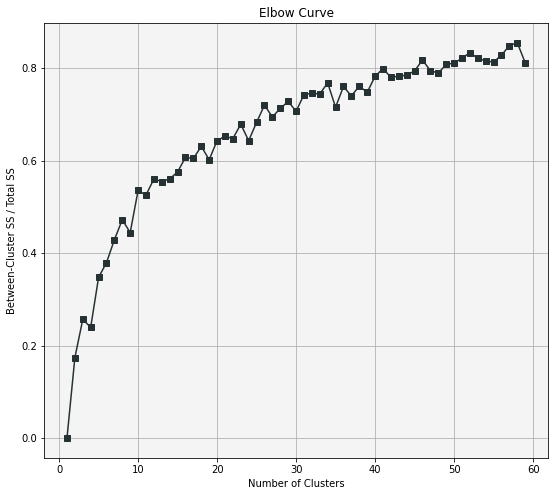

In [31]:
%matplotlib inline
predictors = filmtv_movies_complete.get_columns(
                        exclude_columns = ["avg_vote",
                                           "period",
                                           "director",
                                           "language_area",
                                           "title", 
                                           "year",
                                           "country",
                                           "Category",
                                           "filmtv_id"])
from verticapy.learn.plot import elbow
elbow = elbow(predictors,
              "filmtv_movies_complete_clustering",
              n_cluster = (1, 60))

By looking at the Elbow curve, we can choose 15 clusters. Let's create a KMeans model.

In [32]:
from verticapy.learn.cluster import KMeans
model_kmeans = KMeans("filmtv_movies_clustering", n_cluster = 15)
model_kmeans.drop()
model_kmeans.fit("filmtv_movies_complete_clustering", predictors)
model_kmeans.cluster_centers

<object>

Let's add the clusters in the vDataFrame.

In [33]:
model_kmeans.predict(filmtv_movies_complete, 
                     name = "movies_cluster")

<object>  Name: filmtv_movies_complete, Number of rows: 50898, Number of columns: 39

Let's look at the different clusters.

In [34]:
filmtv_movies_complete.search("movies_cluster = 0",
                              usecols = ["avg_vote",
                                         "period",
                                         "director",
                                         "language_area",
                                         "title", 
                                         "year",
                                         "country",
                                         "Category"])

<object>  Name: search, Number of rows: 2387, Number of columns: 8

In [35]:
filmtv_movies_complete.search("movies_cluster = 1",
                              usecols = ["avg_vote",
                                         "period",
                                         "director",
                                         "language_area",
                                         "title", 
                                         "year",
                                         "country",
                                         "Category"])

<object>  Name: search, Number of rows: 2623, Number of columns: 8

In [36]:
filmtv_movies_complete.search("movies_cluster = 2",
                              usecols = ["avg_vote",
                                         "period",
                                         "director",
                                         "language_area",
                                         "title", 
                                         "year",
                                         "country",
                                         "Category"])

<object>  Name: search, Number of rows: 6159, Number of columns: 8

In [37]:
filmtv_movies_complete.search("movies_cluster = 3",
                              usecols = ["avg_vote",
                                         "period",
                                         "director",
                                         "language_area",
                                         "title", 
                                         "year",
                                         "country",
                                         "Category"])

<object>  Name: search, Number of rows: 1366, Number of columns: 8

Each cluster will represent films which are similar. These clusters can be used to do movie recommendations and help streaming platform to group movies in a more precise way.

## Conclusion

We have solved this use-case in a pandas-like way but we never loaded the data in memory. This example showed an overview of the library. You can now start your own project by looking at the documentation first.